# IMDB-Sentiment Analysis Project

In [1]:
import csv
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
file_path = 'data/labeledTrainData.tsv'

In [3]:
def obtain_data_frame_from_file_path(file_path):

    tsv_file = open(file_path, encoding='utf-8')
    read_tsv = csv.reader(tsv_file, delimiter='\t')
    df_list = list()

    for row in read_tsv:
        df_list.append(row)
    df = pd.DataFrame(df_list[1:], columns=df_list[0])

    return df

In [4]:
df = obtain_data_frame_from_file_path(file_path)
df.shape # (rows, columns)

(13762, 3)

In [5]:
df.head(5)

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [6]:
df.sentiment.value_counts()

1    6922
0    6840
Name: sentiment, dtype: int64

In [7]:
# Normalized value counts
df.sentiment.value_counts(normalize=True)

1    0.502979
0    0.497021
Name: sentiment, dtype: float64

These two values are close to even, `sentiment` column can be considered **balanced**. In this case, **accuracy** is an appropiate metric to assess the quality of the model. Otherwise you could use **F1-score** for example.

I plot the `sentiment` column value counts by calling the `plot()` function. The bar plot is quite informative.

<AxesSubplot:>

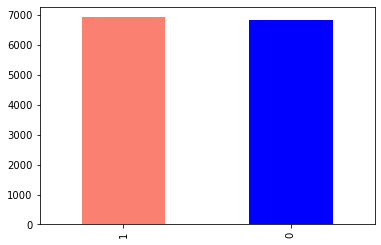

In [8]:
df.sentiment.value_counts().plot(kind="bar", color=["salmon", "blue"])

I use `df.info()` to see if there were any missing values.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13762 entries, 0 to 13761
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         13762 non-null  object
 1   sentiment  13762 non-null  object
 2   review     13762 non-null  object
dtypes: object(3)
memory usage: 322.7+ KB


## Preprocessing

Install **bs4** (Beautiful Soup) library - which is used for remove HTML Tags.


Install **gensim** library - which is used for advanced Natural Language Processing. In this case to remove stopwords.

In [10]:
!pip install bs4
!pip install gensim

In [11]:
import re
from bs4 import BeautifulSoup
from gensim.parsing.preprocessing import remove_stopwords

In [12]:
def eliminate_html_tags(review_text):
    soup = BeautifulSoup(review_text, 'html.parser')
    return soup.get_text(separator=' ')


def eliminate_special_characters(review_text):
    pattern = r'[^a-zA-Z\s]'
    return re.sub(pattern, ' ', review_text)


def preprocess_the_text(review_text):
    review_text = eliminate_html_tags(review_text)
    review_text = eliminate_special_characters(review_text)
    review_text = review_text.lower()
    review_text = remove_stopwords(review_text)
    return review_text


In [13]:
df['review'] = df['review'].apply(preprocess_the_text)

## 1. Vectorize review texts

In [14]:
vectorizer = CountVectorizer(min_df=0.001, lowercase=False)
vectorizer.fit(df['review'])

CountVectorizer(lowercase=False, min_df=0.001)

## 2. Train two models: Logistic Regression and Random Forest

In [15]:
reviews = df['review'].values
sentiments = df['sentiment'].values

In [16]:
test_size_ = 0.2
random_seed = 42

In [17]:
reviews_train, review_test, y_train, y_test = train_test_split(reviews,
                                                                  sentiments,
                                                                  test_size=test_size_,
                                                                  random_state = random_seed)

In [18]:
X_train = vectorizer.transform(reviews_train)
X_test = vectorizer.transform(review_test)

In [19]:
def train_models(X_train, X_test, y_train, y_test, random_seed):

    lr_classifier = LogisticRegression(random_state=random_seed)

    print("Train Logistic Regression model.")
    lr_classifier.fit(X_train, y_train)
    score = lr_classifier.score(X_test, y_test)
    print('Accuracy obtained by Logistic Regression: {:.2f}%'.format(score * 100))

    rf_classifier = RandomForestClassifier(n_estimators=200,
                                           n_jobs=-1,
                                           random_state=random_seed)
    print("\nTrain Random Forest Classifier model.")
    rf_classifier.fit(X_train, y_train)
    score = rf_classifier.score(X_test, y_test)
    print('Accuracy obtained by Random Forest Classifier: {:.2f}%'.format(score * 100))

    return (lr_classifier, rf_classifier)

In [20]:
rf_model, lr_model = train_models(X_train, X_test,
                                     y_train, y_test,
                                     random_seed)

Train Logistic Regression model.


C:\Users\Sorin\Project\MyEnvironment\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy obtained by Logistic Regression: 86.92%

Train Random Forest Classifier model.
Accuracy obtained by Random Forest Classifier: 84.96%


It's that the Logistic Regression Model gives a slightly higer quality result than Random Forest.

## 3. Compare the value of `Accuracy metric` accross two models using cross-validation.

In [21]:
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [22]:
def apply_cross_validation(X, y, model):

    cv_ = KFold(n_splits=5, random_state=42, shuffle=True)
    scores = cross_val_score(model,
                             X, y,
                             scoring='accuracy',
                             cv=cv_,
                             n_jobs=-1)

    print(scores)
    print('Accuracy obtained by Random Forest Classifier: {:.2f}%, ({:.4f})'.format(mean(scores)*100, std(scores)))

    return mean(scores)

In [23]:
X = vectorizer.transform(reviews)
y = sentiments

In [24]:
lr_model = LogisticRegression(random_state=random_seed)

In [25]:
print("\nK-Fold cross-validation for Logistic Regression model.") 
apply_cross_validation(X, y, lr_model)


K-Fold cross-validation for Logistic Regression model.
[0.86923356 0.86705412 0.85901163 0.84593023 0.84665698]
Accuracy obtained by Random Forest Classifier: 85.76%, (0.0098)


0.8575773046739709

In [26]:
rf_model = RandomForestClassifier(random_state=random_seed)

In [27]:
print("\nK-Fold cross-validation for Random Forest model.")
apply_cross_validation(X, y, rf_model)


K-Fold cross-validation for Random Forest model.
[0.8459862  0.84998184 0.83648256 0.83938953 0.83030523]
Accuracy obtained by Random Forest Classifier: 84.04%, (0.0069)


0.8404290720904889

The value of the **Accuracy metric** accross two models using cross-validation is higher in the case of the **logistic regression**.

## 4. Find the optimal parameters for the model that performs better using GridSearch

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [29]:
def find_the_optimal_parameters_using_GridSearch(X, y,
                                                  model,
                                                  param_grid_):
    print("Grid Search")
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid_,
                               cv=5,
                               scoring='accuracy',
                               n_jobs=-1,
                               verbose=2)
    grid_search.fit(X, y)

    best_model = grid_search.best_estimator_
    best_model_accuracy = cross_val_score(best_model, X, y, scoring='accuracy').mean()
    print('Accuracy obtained by best model: {:.2f}%'.format(best_model_accuracy * 100))

    return grid_search.best_params_

In [30]:
rf_model = RandomForestClassifier(random_state=random_seed)

In [31]:
param_grid = {
      'n_estimators': [100, 200, 500, 1000],
      'max_features': ['auto', 'sqrt', 'log2'],
      'max_depth': [10, 15, 20, 30, 50],
      'criterion': ['gini', 'entropy']
   }

In [32]:
find_the_optimal_parameters_using_GridSearch(X, y, rf_model, param_grid)

Grid Search
Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 22.0min finished


Accuracy obtained by best model: 86.41%


{'criterion': 'entropy',
 'max_depth': 50,
 'max_features': 'log2',
 'n_estimators': 1000}

In [33]:
lr_model = LogisticRegression(random_state=random_seed)

In [34]:
param_grid = {
      'penalty': ['l2', 'none'],
      'tol': [1e-4, 1e-5, 1e-6],
      'C': [0.01, 0.1, 1.0, 10],
      'max_iter': [100, 200, 500]
   }

In [35]:
find_the_optimal_parameters_using_GridSearch(X, y, lr_model, param_grid)

Grid Search
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.3min finished


Accuracy obtained by best model: 86.90%


{'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'tol': 0.0001}

## Conclusions

To increase the accuracy of the model you can try the following steps:
- Stemming and Lemmatization, to reduce a word to its root form;
- Try other parameters to find more optimal ones using Grid Search CV;
- Try Random Search CV;
- Try another models like: Deep Learning, SVM, Naive Bayes and other.